In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import pairwise_distances
from mpl_toolkits.mplot3d import Axes3D
import swifter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import GlobalMaxPooling2D

In [7]:
DATASET_PATH = "./myntradataset/"
df = pd.read_csv(DATASET_PATH + "styles.csv", nrows=5000, error_bad_lines=False) #CSV 를 읽어와서 pandas 의 dataframe 을 만든다.
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)

In [9]:
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
     
def img_path(img):
    return DATASET_PATH+"/images/"+img

def load_image(img):
    return cv2.imread(img_path(img))

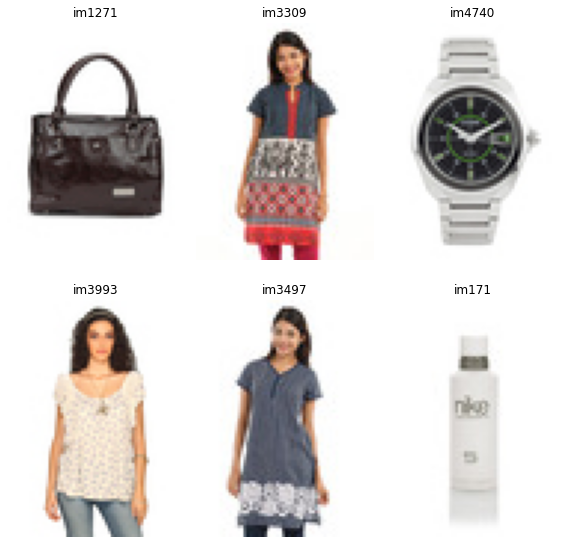

In [14]:
figures = {'im'+str(i): load_image(row.image) for i, row in df.sample(6).iterrows()}
plot_figures(figures, 2, 3)

아까처럼 base_model 에 합성곱 신경망인 ResNet 을 가져다 쓸 것인데
이번에는 훈련을 시키지 않음. ResNet을 통해 사진의 특성만 잡아내는것이 목적

In [12]:
img_width, img_height, _ = load_image(df.iloc[0].image).shape
 
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape = (img_width, img_height, 3))
base_model.trainable = False
 
model = tf.keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])
 
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 3, 2, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [15]:
def get_embedding(model, img_name):
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    x   = image.img_to_array(img)
    x   = np.expand_dims(x, axis=0)
    x   = preprocess_input(x) # 여기 까지가 이미지를 받아서 전처리 까지 
    return model.predict(x).reshape(-1)

In [16]:
%%time
map_embeddings = df['image'].swifter.apply(lambda img: get_embedding(model, img))
df_embs        = map_embeddings.apply(pd.Series)
print(df_embs.shape)
df_embs.head()


Pandas Apply:   0%|          | 0/5000 [00:00<?, ?it/s]

(5000, 2048)
CPU times: user 10min 11s, sys: 38.6 s, total: 10min 50s
Wall time: 6min 6s


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.000000,3.539255,0.000000,1.094595,0.000000,0.000000,4.458538,2.446018,2.678128,0.0,...,0.424306,0.0000,0.000000,5.880397,0.000000,0.000000,6.428889,4.408070,0.950039,1.847201
1,1.879336,1.600882,0.092033,4.433074,0.000000,0.000000,3.030766,8.530594,5.498658,0.0,...,2.808288,0.0000,3.923479,3.183100,0.000000,0.000000,4.244203,3.268896,2.271731,5.433387
2,0.000000,0.311197,0.000000,3.808685,0.437029,7.112499,0.000000,0.000000,0.000000,0.0,...,0.218205,7.8613,1.655931,0.000000,0.000000,0.000000,4.703016,0.000000,2.340579,0.000000
3,0.588016,9.894618,0.000000,6.295309,1.783727,1.913123,0.000000,13.309946,7.805777,0.0,...,22.434376,0.0000,0.000000,0.000000,2.565926,3.330477,0.594363,1.130464,3.084234,7.608924
4,0.000000,1.882975,0.000000,5.122095,0.000000,0.000000,2.950290,6.626864,1.606633,0.0,...,2.504942,0.0000,1.274128,3.484579,0.786350,0.000000,1.597858,2.515497,0.068350,0.000000


저렇게 5000개의 그림이 모델을 통과하면, 5000 개의 2048 크기의 벡터가 된다.
이 벡터들 간의 유사도 (cosine similarity) 를 구함으로써 추천 시스템을 구현할 수 있습니다. 

(1,1), (2,3) 의 두 벡터를 생각하면 (두 벡터의 내적) / (두 벡터의 크기) 가 유사도가 됩니다.

consine similarity = <(1,1), (2,3)> /|(1,1)|* |(2,3)| = 1* 2 + 1* 3 / 루트 2 = 루트 25 /루트 26 -1 에 가깝다.


In [17]:
cosine_sim = 1-pairwise_distances(df_embs, metric='cosine')
indices = pd.Series(range(len(df)), index=df.index)
 
def get_recommender(idx, df, top_n = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
     
    return indices.iloc[idx_rec].index, idx_sim
 
get_recommender(2993, df, top_n = 5)

(Int64Index([259, 4305, 0, 2779, 2701], dtype='int64'),
 [0.90409696, 0.8925513, 0.8917555, 0.8855503, 0.88129276])

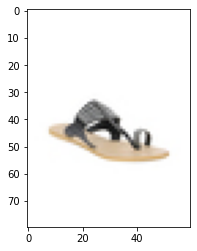

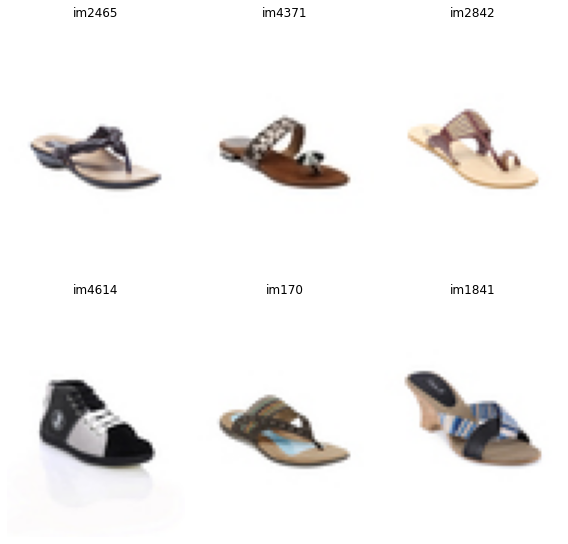

In [19]:
from random import randint
 
idx_ref = randint(1, 5000)
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))
 
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
plot_figures(figures, 2, 3)

In [21]:
df_embs.to_csv('./embeddings.csv')
df.to_csv('metadados.csv')
df.sample(100).to_csv('df_sample.csv')

In [ ]:
from keras.models import load_model
model.save(model, "./model/recommender")